In [1]:
%matplotlib inline
import math
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import powerlaw

In [5]:
data = np.array([1.7, 3.2, 3.5]) # data can be list or numpy array
results = powerlaw.Fit(data)
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')

Calculating best minimal value for power law fit


23.3183999721
3.2


# Simulation

In [8]:
from stockmarket import baselinemodel

In [9]:
#%prun baselinemodel.stockMarketSimulation(seed=0, simulation_time=10, amount_momentum=40, amount_mean_reversion=40, amount_firms=1,initial_money=(100, 200),initial_bid_ask=(1,1), initial_memory=(3,7),initial_ma_short=(2,3), initial_ma_long=(6,7),initial_profit=(200,200),initial_book_value=(10000, 10000),initial_stock_amount=400,order_expiration_time=120,init_propensity_to_switch=1.1,init_price_to_earnings_window=(6, 12),firm_profit_mu=0.058,firm_profit_delta=0.00396825396,firm_profit_sigma=0.125,printProgress=False)

In [10]:
agents, firms, stocks, order_books, market_maker = baselinemodel.stockMarketSimulation(seed=0, simulation_time=500,
                                                                                       amount_momentum=10,
                                                                                       amount_mean_reversion=10,
                                                                                       amount_noise_traders=100,
                                                                                       amount_firms=1,
                                                                                       initial_money=(100, 200),
                                                                                       initial_bid_ask=(1,1),
                                                                                       initial_memory=(3,7),
                                                                                       initial_ma_short=(20,40),
                                                                                       initial_ma_long=(120,150),
                                                                                       initial_profit=(200,200),
                                                                                       initial_book_value=(10000, 10000),
                                                                                       initial_stock_amount=4000,
                                                                                       order_expiration_time=150,
                                                                                       init_propensity_to_switch=1.1,
                                                                                       init_price_to_earnings_window=((4, 7), (10, 14)),
                                                                                       firm_profit_mu=0.058,
                                                                                       firm_profit_delta=0.00396825396,
                                                                                       firm_profit_sigma=0.125,
                                                                                       profit_announcement_working_days=20,
                                                                                       init_market_maker_money=5000,
                                                                                       market_maker_bid_ask_spread=3,
                                                                                       market_maker_price_to_earnings_window=(5,13),
                                                                                       market_maker_inventory_sensitivity=0.01,
                                                                                       market_maker_inventory_buffer_of_total_target=0.10,
                                                                                       m_m_standard_order_percentage_total=0.05,
                                                                                       agents_hold_thresholds=(0.9995, 1.0005),
                                                                                       init_share_of_stocks_to_market_maker=0.4,
                                                                                       init_backward_simulated_time=200,
                                                                                       trader_volume_risk_aversion=0.1,
                                                                                       printProgress=False
                                                                                       )

# Quick results

## Firm profits

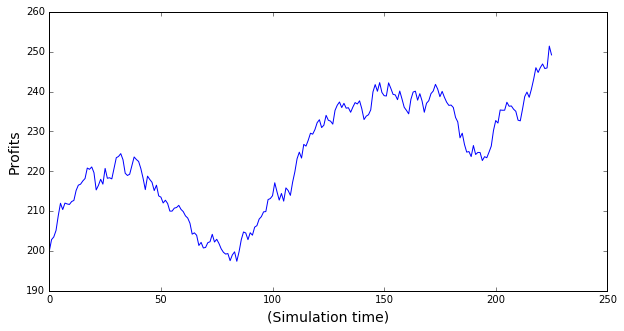

In [11]:
profits = firms[0].profit_history

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(profits)), profits)

ax1.set_ylabel('Profits', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

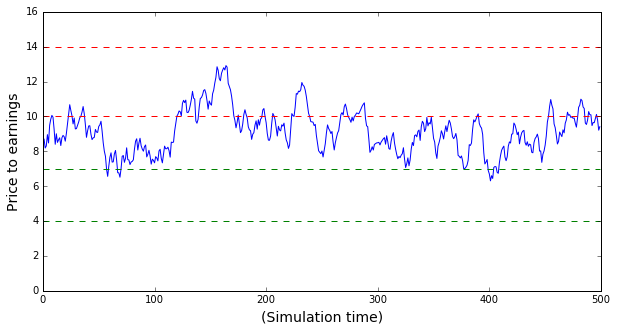

In [12]:
price_to_earnings = stocks[0].price_to_earnings_history

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(price_to_earnings)), price_to_earnings)
ax1.plot(range(len(price_to_earnings)), [4 for x in range(len(price_to_earnings))], 'g--')
ax1.plot(range(len(price_to_earnings)), [7 for x in range(len(price_to_earnings))], 'g--')
ax1.plot(range(len(price_to_earnings)), [10 for x in range(len(price_to_earnings))], 'r--')
ax1.plot(range(len(price_to_earnings)), [14 for x in range(len(price_to_earnings))], 'r--')
#ax1.plot(range(len(price_to_earnings)), )

ax1.set_ylim(0, 16)

ax1.set_ylabel('Price to earnings', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

# Buy and sell orders

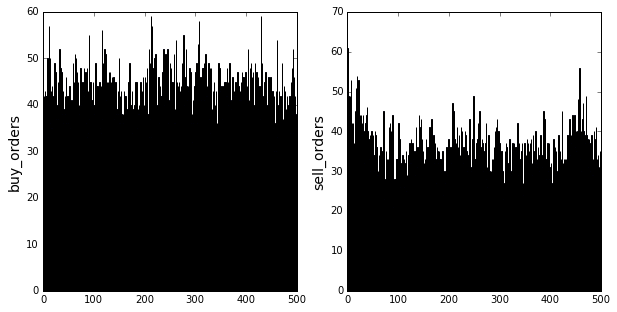

In [13]:
buy_orders = order_books[0].buy_orders_history
sell_orders = order_books[0].sell_orders_history
#sell_orders

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.bar(range(len(buy_orders)), buy_orders)
ax2.bar(range(len(sell_orders)), sell_orders)


ax1.set_ylabel('buy_orders', fontsize='14')
ax2.set_ylabel('sell_orders', fontsize='14')

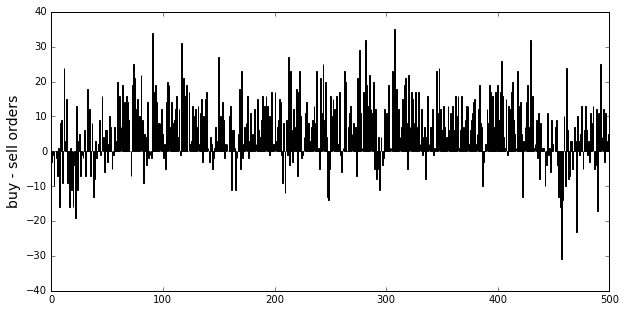

In [14]:
buy_minus_sell_orders = np.array(buy_orders) - np.array(sell_orders)

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.bar(range(len(buy_minus_sell_orders)), buy_minus_sell_orders)


ax1.set_ylabel('buy - sell orders', fontsize='14')

# Market Prices and Volume

In [15]:
prices = order_books[0].transaction_prices_history
averageprices = []
for day in prices:
    averageprices.append(np.mean(day))

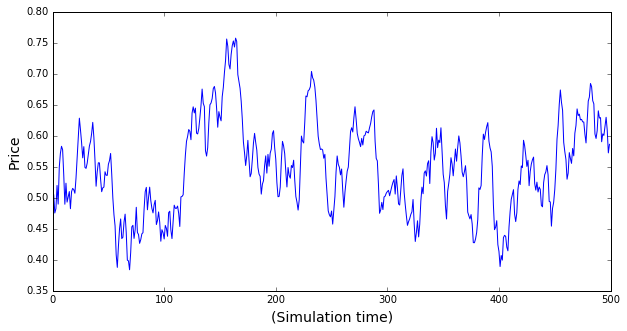

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(averageprices)), averageprices)

ax1.set_ylabel('Price', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

In [17]:
volume = order_books[0].transaction_volumes_history
totalvolume = []
for day in volume:
    totalvolume.append(sum(day))

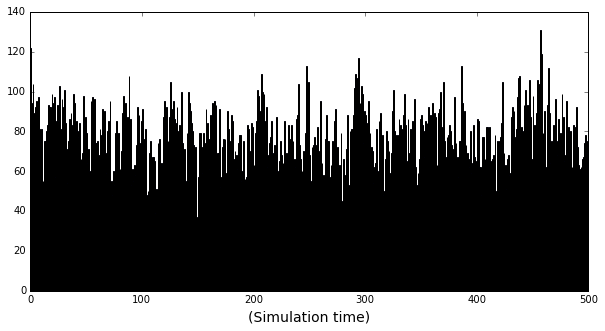

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.bar(range(len(totalvolume)), totalvolume)

ax1.set_xlabel('(Simulation time)', fontsize='14')

## Intraday prices

In [19]:
import itertools

In [20]:
all_transaction_prices = order_books[0].transaction_prices_history

In [21]:
all_transaction_prices = list(itertools.chain.from_iterable(all_transaction_prices))

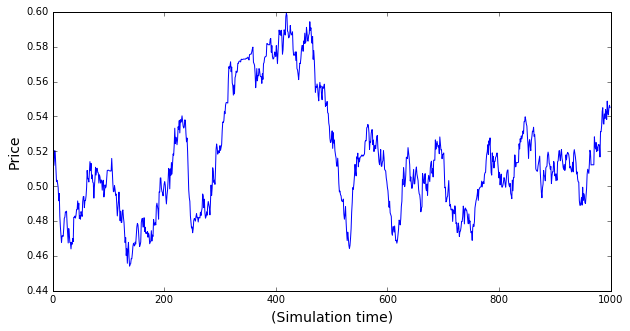

In [22]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

zoomed_prices = all_transaction_prices[:1000]

ax1.plot(range(len(zoomed_prices)), zoomed_prices)

ax1.set_ylabel('Price', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

# Strategy switching

In [23]:
def percentageMomentum(period, agents):
    momentum = 0
    queryString = 'momentum'
    for agent in agents:
        function = str(agent.function_history[period])
        if queryString in function:
            momentum += 1
    return momentum / (len(agents))

In [24]:
percFund = []
for period in range(100):
    percFund.append(percentageMomentum(period, agents))

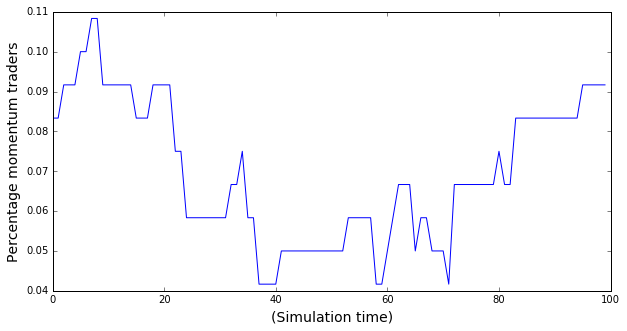

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(percFund)), percFund)

ax1.set_ylabel('Percentage momentum traders', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

# Stylized facts

Most of the text comes from: Rama Cont (2001) Journal of Quantitative Finance

How to replicate these? 
* centrifugal forces (for volatility clusering and fat tails) = mean reversion, trend following & fundamental component)
* very low autocorrelation? ... stochasticity? 
* large positive autocorrelation in volume? 

## 1 Returns

In [110]:
returns = pd.Series(averageprices).diff()
squared_returns = np.square(returns) 

In [124]:
stats = [returns.std(), returns.min(), returns.max(), returns.skew(), returns.kurtosis()]
sp500 = [0.008, -0.082, 0.051, -0.187, 8.512]
index = ['standard_deviation', 'minimum', 'maximum', 'skewness', 'kurtosis']

In [125]:
pd.DataFrame({'Simulation':stats, 'S&P500': sp500}, index=index)

,S&P500,Simulation
standard_deviation,0.008,0.022878
minimum,-0.082,-0.071018
maximum,0.051,0.059378
skewness,-0.187,-0.129489
kurtosis,8.512,-0.413523


### 1.1 Very low autocorrelation

(linear) autocorrelations of asset returns are often insignificant, except for very
small intraday time scales ( 20 minutes) for which microstructure effects come into play.

add a bit of stochasticity? 

In some models such as Ghonghadze & Lux 2016. Changes in the fundamental value are driven by a brownian motion, which in turn drives the low autocorrelations. 

In [108]:
autocorr_returns = [returns.autocorr(lag=lag) for lag in range(25)]
autocorr_squared_returns = [squared_returns.autocorr(lag=lag) for lag in range(25)]

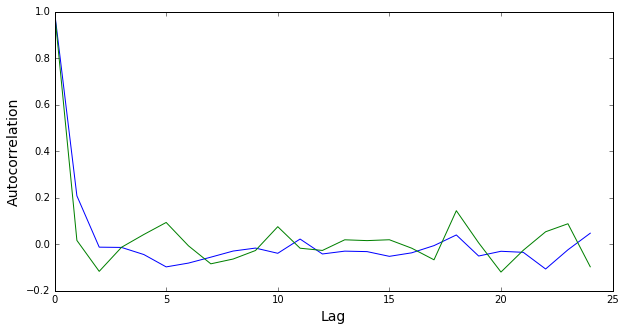

In [109]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))


ax1.plot(range(len(autocorr_returns)), autocorr_returns)
ax1.plot(range(len(autocorr_squared_returns)), autocorr_squared_returns)

ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

### 1.2 Fait tails

fat tails of the unconditional distribution
of returns

In [141]:
import scipy.stats as stats

(array([  0.30737201,   1.22948805,   5.07163821,  10.60433444,
         12.90962453,  16.29071667,  14.29279859,   9.98959041,
          4.7642662 ,   1.22948805]),
 array([-0.07101839, -0.05797876, -0.04493914, -0.03189951, -0.01885989,
        -0.00582026,  0.00721936,  0.02025899,  0.03329862,  0.04633824,
         0.05937787]),
 <a list of 10 Patch objects>)

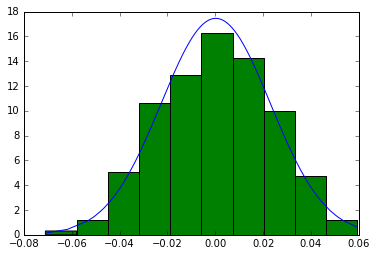

In [158]:
h = sorted(list(returns[1:]))
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf)
plt.hist(h, normed=True)

In [128]:
absolute_returns = returns.abs()
autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(25)]

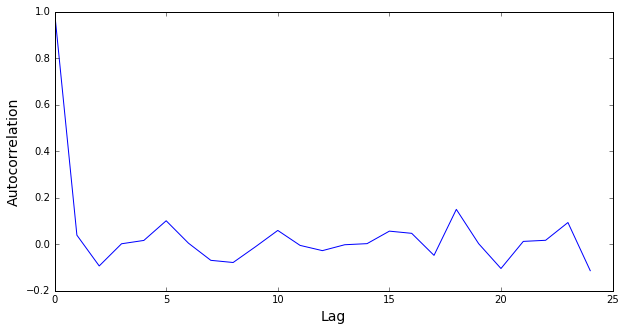

In [129]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(autocorr_abs_returns)), autocorr_abs_returns)

ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

### 1.3 Clustered volatility

Volatility clustering characterizing their conditional distribution. Probably tied to over-optimism / over pessimism. 

In [ ]:
# one measure for persistent volatility is plotting the autocorrelation of the absolute retunrs


## 2 Volume
### 2.1 Large positive autocorrelation

In [27]:
vol = pd.Series(totalvolume)

In [28]:
autocorr_volume = [vol.autocorr(lag=lag) for lag in range(25)]

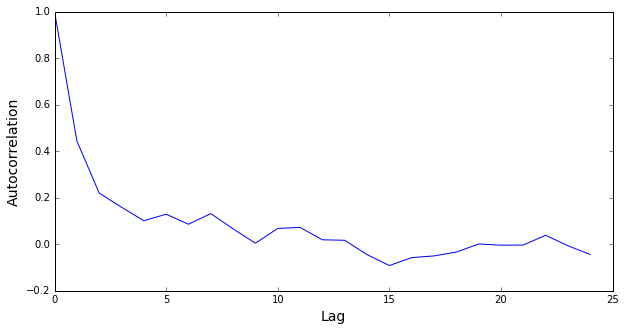

In [29]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(autocorr_volume)), autocorr_volume)


ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

### 2.2 Correlation between high price volatility and large volumes

## 3 Prices

### 3.1 Moving P/E ratio

# Long memory

In [424]:
def hurst(price_series):
    """
    see:
    https://www.quantopian.com/posts/some-code-from-ernie-chans-new-book-implemented-in-python
    
    Function to calculate the hurst exponent
    """
    tau = []; lagvec = []  
    #  Step through the different lags  
    for lag in range(2,20):  
        #  produce price difference with lag  
        pp = subtract(p[lag:],price_series[:-lag])  
        #  Write the different lags into a vector  
        lagvec.append(lag)  
        #  Calculate the variance of the differnce vector  
        tau.append(sqrt(std(pp)))  
    #  linear fit to double-log graph (gives power)  
    m = polyfit(log10(lagvec),log10(tau),1)  
    # calculate hurst  
    hurst = m[0]*2  
    # plot lag vs variance  
    #py.plot(lagvec,tau,'o'); show()  
    return hurst  